In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv('Gold_data.csv',parse_dates=["date"],index_col='date')

In [3]:
data.head()

,price
date,
2016-01-01,2252.60
2016-01-02,2454.50
2016-01-03,2708.10
2016-01-04,2577.80
2016-01-05,2597.75


In [4]:
data.tail()

,price
date,
2021-12-17,4394.4
2021-12-18,4389.5
2021-12-19,4389.5
2021-12-20,4354.1
2021-12-21,4346.5


In [5]:
data.columns

Index(['price'], dtype='object')

In [6]:
data.shape

(2182, 1)

In [7]:
data.dtypes

price    float64
dtype: object

In [8]:
data.describe()

,price
count,2182.000000
mean,3284.450046
std,719.564434
min,2252.600000
25%,2697.020000
50%,2879.800000
75%,4147.325000
max,4966.300000


### Box Plot

<AxesSubplot:>

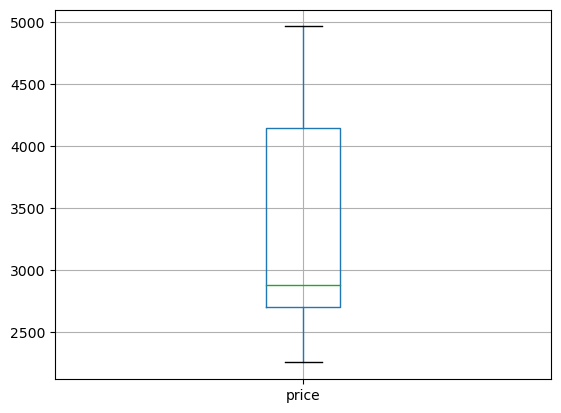

In [9]:
data.boxplot(column=['price'])

In [10]:
data.isna().sum()

price    0
dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2182 entries, 2016-01-01 to 2021-12-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2182 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB


In [12]:
data.duplicated()

date
2016-01-01    False
2016-01-02    False
2016-01-03    False
2016-01-04    False
2016-01-05    False
              ...  
2021-12-17    False
2021-12-18    False
2021-12-19     True
2021-12-20    False
2021-12-21    False
Length: 2182, dtype: bool

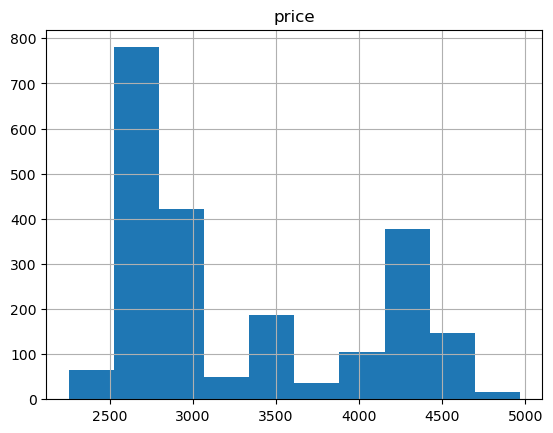

In [13]:
data.hist()
plt.show()

### Line Plot

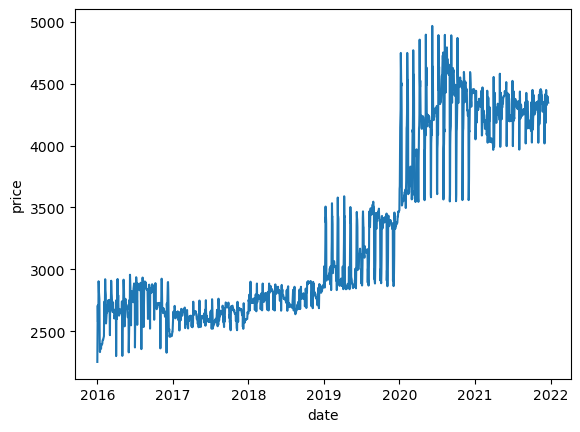

In [14]:
sns.lineplot(data=data,x=data.index,y=data.price)
plt.show()

### Scatter Plot

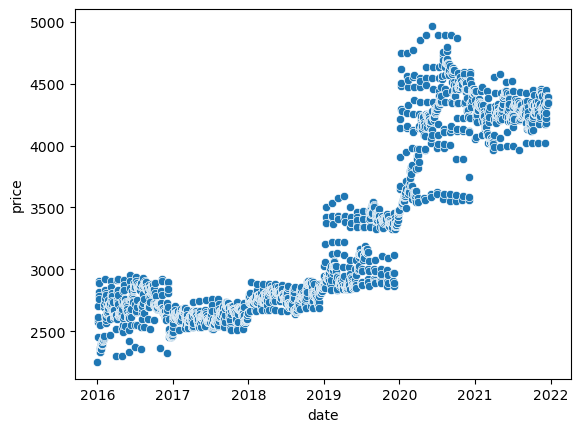

In [15]:
sns.scatterplot(data=data, x="date", y="price")
plt.show()

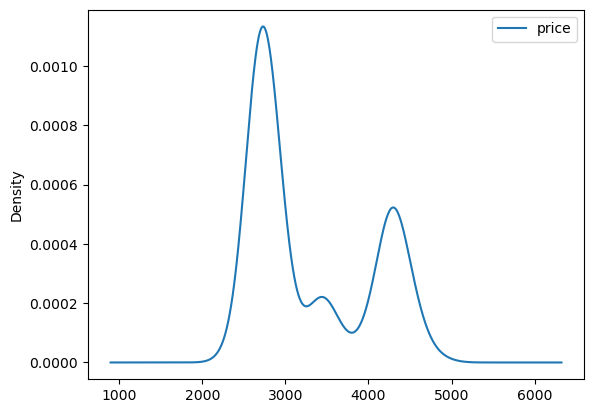

In [16]:
data.plot(kind='kde')
plt.show()

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

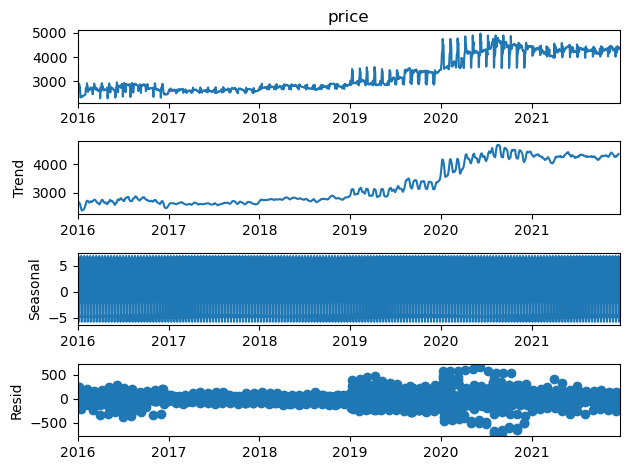

In [18]:
decompose=seasonal_decompose(data.price,period=12)
decompose.plot()
plt.show()

In [19]:
data.drop_duplicates(inplace=True)

In [20]:
data

,price
date,
2016-01-01,2252.60
2016-01-02,2454.50
2016-01-03,2708.10
2016-01-04,2577.80
2016-01-05,2597.75
...,...
2021-12-16,4399.80
2021-12-17,4394.40
2021-12-18,4389.50


In [21]:
data.shape

(1876, 1)

### Resampling

In [22]:
new=data.resample('m').mean()
new

,price
date,
2016-01-31,2495.832258
2016-02-29,2688.703448
2016-03-31,2682.854839
2016-04-30,2684.314286
2016-05-31,2677.650000
...,...
2021-08-31,4263.014815
2021-09-30,4208.151852
2021-10-31,4287.908000


### Seasonal Decompose

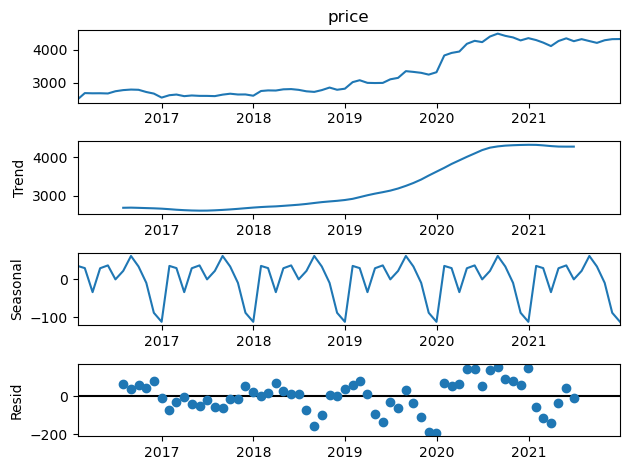

In [23]:
decompose=seasonal_decompose(new.price,period=12)
decompose.plot()
plt.show()

### AD Fuller Test

In [24]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [25]:
adf_test(new['price'])

Fail to reject the null hypothesis
Data is non-stationary


### ACF and PACF

In [26]:
import statsmodels.graphics.tsaplots as sgt
from matplotlib import pyplot as plt

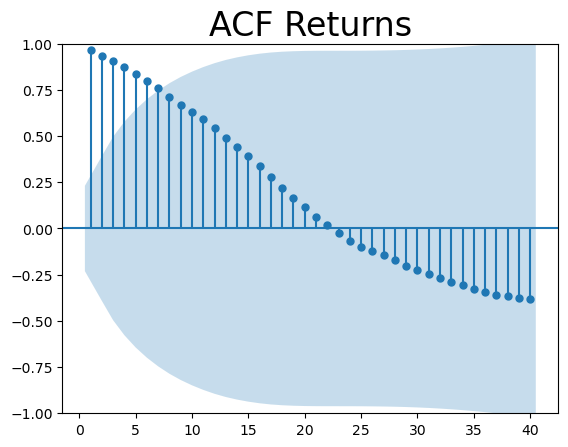

In [27]:
sgt.plot_acf(new.price, lags=40, zero = False)
plt.title("ACF Returns", size=24)
plt.show()

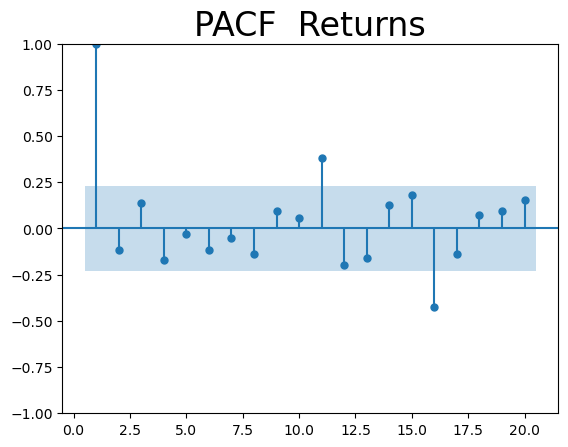

In [28]:
sgt.plot_pacf(new.price, lags = 20, zero = False, method = ('ols'))
plt.title("PACF  Returns", size=24)
plt.show()

# Model Building

### Trian Test Split

In [29]:
train = new.iloc[0:71,:]
test = new.iloc[71,:]

In [30]:
train_original = train.copy()
test_original = test.copy()

In [31]:
train1 = train.copy()

### Model 1 - Simple Expo Smoothing

In [32]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
alpha = 0.15

In [33]:
model_ses12=SimpleExpSmoothing(train['price'])
fitted_model= model_ses12.fit(smoothing_level=alpha,optimized=False)
fitted_model.fittedvalues

date
2016-01-31    2495.832258
2016-02-29    2495.832258
2016-03-31    2524.762937
2016-04-30    2548.476722
2016-05-31    2568.852356
                 ...     
2021-07-31    4210.040745
2021-08-31    4226.745258
2021-09-30    4232.185692
2021-10-31    4228.580616
2021-11-30    4237.479723
Freq: M, Length: 71, dtype: float64

In [34]:
train['SES12'] = fitted_model.fittedvalues.shift(-1)

### Model 2 - Double Exponential

In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

mod_add12 = ExponentialSmoothing(train['price'], trend='add')
fitted_DESadd12 = mod_add12.fit()
train['DESadd12'] = fitted_DESadd12.fittedvalues.shift(-1)

In [36]:
fitted_DESmul12 = ExponentialSmoothing(train['price'], trend='mul').fit()
train['DESmul12'] = fitted_DESmul12.fittedvalues.shift(-1)

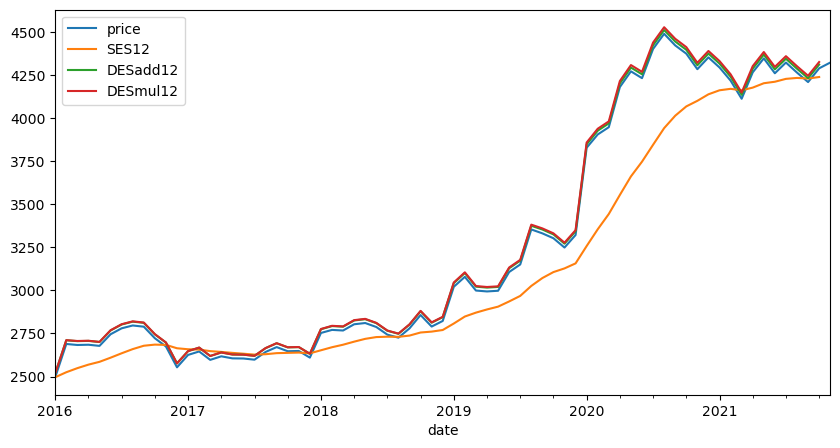

In [37]:
train[['price','SES12','DESadd12','DESmul12']].plot(figsize=(10,5))
plt.show();

### Model 3 - Triple Expo Smoothing

In [38]:
fitted_TESadd12 = ExponentialSmoothing(train['price'],trend='add',seasonal='add',seasonal_periods=12).fit()
train['TESadd12'] = fitted_TESadd12.fittedvalues

In [39]:
fitted_TESmul12 = ExponentialSmoothing(train['price'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
train['TESmul12'] = fitted_TESmul12.fittedvalues

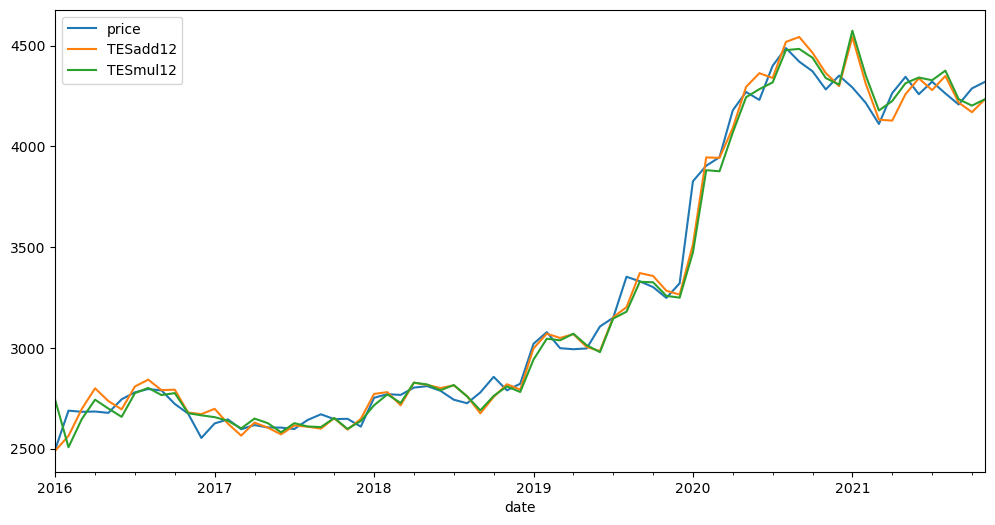

In [40]:
train[['price','TESadd12','TESmul12']].plot(figsize=(12,6))
plt.show();

### Model 4 - Holts Method

In [41]:
from statsmodels.tsa.holtwinters import Holt
hw_model = Holt(train["price"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
train['hw'] = hw_model.fittedvalues.shift(-1)

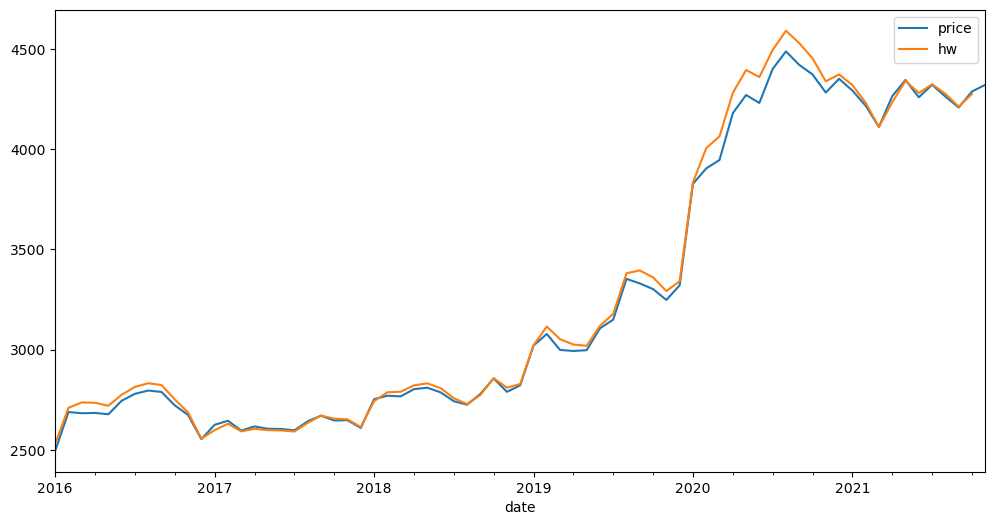

In [42]:
train[['price','hw']].plot(figsize=(12,6))
plt.show();

### Model Evaluation

In [43]:
def mape(actual,pred):
    return round((np.mean(abs(actual-pred)/actual))*100,2)

###### RMSE DESadd

In [44]:
# Test
test_pred1 = fitted_DESadd12.forecast(1)

In [45]:
from sklearn.metrics import mean_absolute_error , mean_squared_error

In [46]:
rmse_DESadd_test = np.sqrt(mean_squared_error(test,test_pred1))
mape_DESadd_test = mape(test.values, test_pred1.values)

In [47]:
# Train
train_pred1 = fitted_DESadd12.predict(0)
rmse_DESadd_train = np.sqrt(mean_squared_error(train_original, train_pred1))
mape_DESadd_train = mape(train_original.values, train_pred1.values)

###### RMSE DESmul

In [48]:
# Test
test_pred2 = fitted_DESmul12.forecast(1)

In [49]:
rmse_DESmul_test = np.sqrt(mean_squared_error(test,test_pred2))
mape_DESmul_test = mape(test.values, test_pred2.values)

In [50]:
# Train
train_pred2 = fitted_DESmul12.predict(0)
rmse_DESmul_train = np.sqrt(mean_squared_error(train_original, train_pred2))
mape_DESmul_train = mape(train_original.values, train_pred2.values)

###### RMSE TESadd

In [51]:
#Test
test_pred3 = fitted_TESadd12.forecast(1)

In [52]:
rmse_TESadd_test = np.sqrt(mean_squared_error(test,test_pred3 ))
mape_TESadd_test = mape(test.values, test_pred3.values)

In [53]:
#Train
pred3_train = fitted_TESadd12.predict(0)

In [54]:
rmse3_train = np.sqrt(mean_squared_error(train_original,pred3_train))
mape_TESadd_train = mape(train_original.values, pred3_train.values)

###### RMSE TESmul

In [55]:
# Test
test_pred4 = fitted_TESmul12.forecast(1)

In [56]:
rmse4 = np.sqrt(mean_squared_error(test,test_pred4 ))
mape_TESmul_test = mape(test.values, test_pred4.values)

In [57]:
# Train
pred_train_TESmul12 = fitted_TESmul12.predict(0)

In [58]:
rmse4_train = np.sqrt(mean_squared_error(train_original,pred_train_TESmul12 ))
mape_TESmul_train = mape(train_original.values, pred_train_TESmul12.values)

###### RMSE Holts

In [59]:
# Test
test_pred5 = hw_model.forecast(1)

In [60]:
rmse5 = np.sqrt(mean_squared_error(test,test_pred5 ))
mape_holt_test = mape(test.values, test_pred5.values)

In [61]:
# Train
pred_train_hw = hw_model.predict(0)

In [62]:
rmse5_train_hw = np.sqrt(mean_squared_error(train_original, pred_train_hw ))
mape_holt_train = mape(train_original.values, pred_train_hw.values)

In [63]:
results_df = pd.DataFrame({'Test RMSE': [rmse_DESadd_test]}, index=['DESadd'])
r1 = pd.DataFrame({'Test RMSE': [rmse_DESmul_test]},index=['DESmul'])
r2 = pd.DataFrame({'Test RMSE': [rmse_TESadd_test]},index=['TESadd'])
r3 = pd.DataFrame({'Test RMSE': [rmse4]},index=['TESmul'])
r4 = pd.DataFrame({'Test RMSE': [rmse5]},index=['Holts'])
results_df = pd.concat([results_df,r1,r2,r3,r4])
results_df

,Test RMSE
DESadd,18.928162
DESmul,33.851372
TESadd,4.586329
TESmul,5.917666
Holts,2.435487


In [64]:
results_df2 = pd.DataFrame({'Train RMSE': [rmse_DESadd_train]}, index=['DESadd'])
t2 = pd.DataFrame({'Train RMSE': [rmse_DESmul_train]}, index=['DESmul'])
t3 = pd.DataFrame({'Train RMSE': [rmse3_train]}, index=['TESadd'])
t4 = pd.DataFrame({'Train RMSE': [rmse4_train]}, index=['TESmul'])
t5 = pd.DataFrame({'Train RMSE': [rmse5_train_hw]}, index=['Holts'])
results_df2 = pd.concat([results_df2,t2,t3,t4,t5])
results_df2

,Train RMSE
DESadd,96.211070
DESmul,96.428203
TESadd,80.708836
TESmul,86.925677
Holts,100.038697


In [65]:
result_rmse = pd.concat([results_df,results_df2])

### RMSE

In [66]:
result_rmse

,Test RMSE,Train RMSE
DESadd,18.928162,NaN
DESmul,33.851372,NaN
TESadd,4.586329,NaN
TESmul,5.917666,NaN
Holts,2.435487,NaN
DESadd,NaN,96.211070
DESmul,NaN,96.428203
TESadd,NaN,80.708836
TESmul,NaN,86.925677
Holts,NaN,100.038697


### MAPE

In [67]:
results_df3 = pd.DataFrame({'Test MAPE %': [mape_DESadd_test]}, index=['DESadd'])
rr1 = pd.DataFrame({'Test MAPE %': [mape_DESmul_test]},index=['DESmul'])
rr2 = pd.DataFrame({'Test MAPE %': [mape_TESadd_test]},index=['TESadd'])
rr3 = pd.DataFrame({'Test MAPE %': [mape_TESmul_test]},index=['TESmul'])
rr4 = pd.DataFrame({'Test MAPE %': [mape_holt_test]},index=['Holts'])
results_df3 = pd.concat([results_df3,rr1,rr2,rr3,rr4])
results_df3

,Test MAPE %
DESadd,0.44
DESmul,0.78
TESadd,0.11
TESmul,0.14
Holts,0.06


In [68]:
results_df4 = pd.DataFrame({'Train MAPE %': [mape_DESadd_train]}, index=['DESadd'])
tt2 = pd.DataFrame({'Train MAPE %': [mape_DESmul_train]}, index=['DESmul'])
tt3 = pd.DataFrame({'Train MAPE %': [mape_TESadd_train]}, index=['TESadd'])
tt4 = pd.DataFrame({'Train MAPE %': [mape_TESmul_train]}, index=['TESmul'])
tt5 = pd.DataFrame({'Train MAPE %': [mape_holt_train]}, index=['Holts'])
results_df4 = pd.concat([results_df4,tt2,tt3,tt4,tt5])
results_df4

,Train MAPE %
DESadd,22.62
DESmul,22.75
TESadd,22.96
TESmul,22.83
Holts,23.01


In [69]:
result_mape = pd.concat([results_df3,results_df4])

In [70]:
result_mape

,Test MAPE %,Train MAPE %
DESadd,0.44,NaN
DESmul,0.78,NaN
TESadd,0.11,NaN
TESmul,0.14,NaN
Holts,0.06,NaN
DESadd,NaN,22.62
DESmul,NaN,22.75
TESadd,NaN,22.96
TESmul,NaN,22.83
Holts,NaN,23.01


# Auto Regression Models

In [71]:
adf_test(train['price'])

Fail to reject the null hypothesis
Data is non-stationary


In [72]:
# First order differencing (I = 1)
from statsmodels.tsa.statespace.tools import diff
df = diff(train['price'],k_diff=1)
adf_test(df)

Reject the null hypothesis
Data is stationary


## ARMA Model

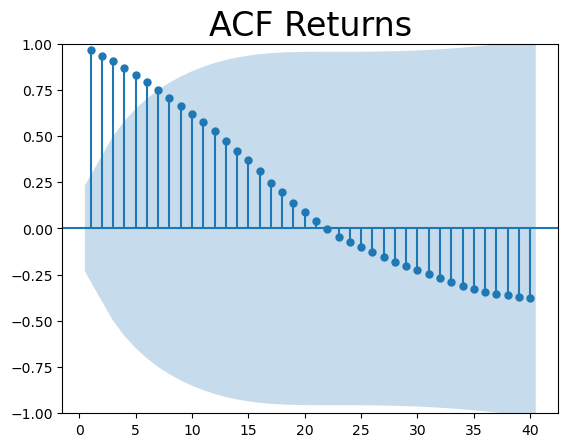

In [73]:
sgt.plot_acf(train.price, lags=40, zero = False)
plt.title("ACF Returns", size=24)
plt.show()

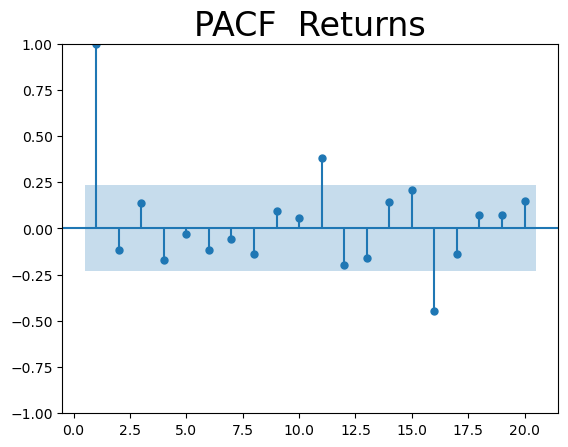

In [74]:
sgt.plot_pacf(train.price, lags = 20, zero = False, method = ('ols'))
plt.title("PACF  Returns", size=24)
plt.show()

In [75]:
from statsmodels.tsa.arima.model import ARIMA

In [76]:
# P =1, q = 5
model_ar_1_ma_5 = ARIMA(df, order=(1,0,5))
results_ar_1_ma_5 = model_ar_1_ma_5.fit()
results_ar_1_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   70
Model:                 ARIMA(1, 0, 5)   Log Likelihood                -413.299
Date:                Tue, 10 Jan 2023   AIC                            842.598
Time:                        13:18:13   BIC                            860.586
Sample:                    02-29-2016   HQIC                           849.743
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.0454     23.113      1.127      0.260     -19.256      71.347
ar.L1          0.2261      0.348      0.651      0.515      -0.455       0.907
ma.L1         -0.0197      0.415     -0.048      0.962      -0.832       0.793
ma.L2         -0.3324      0.157     -2.122      0.034      -0.639      -0.025
ma.L3          0.3141      0.189      1.660      0.097      -0.057       0.685
ma.L4          0.0295      0.172      0.171      0.864      -0.308       0.367
ma.L5          0.3385      0.121      2.797      0.005       0.101       0.576
sigma2      7581.5296   1540.700      4.921      0.000    4561.814    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                30.88
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               4.17   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
# P =1, q = 6
model_ar_1_ma_6 = ARIMA(df, order=(1,0,6))
results_ar_1_ma_6 = model_ar_1_ma_6.fit()
results_ar_1_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   70
Model:                 ARIMA(1, 0, 6)   Log Likelihood                -413.101
Date:                Tue, 10 Jan 2023   AIC                            844.201
Time:                        13:18:14   BIC                            864.438
Sample:                    02-29-2016   HQIC                           852.239
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.0281     17.642      1.475      0.140      -8.550      60.606
ar.L1          0.9744      0.589      1.653      0.098      -0.181       2.129
ma.L1         -0.8214      1.160     -0.708      0.479      -3.095       1.452
ma.L2         -0.4747      0.236     -2.014      0.044      -0.937      -0.013
ma.L3          0.5213      0.376      1.386      0.166      -0.216       1.258
ma.L4         -0.1325      0.339     -0.391      0.696      -0.796       0.531
ma.L5          0.2222      0.186      1.195      0.232      -0.142       0.587
ma.L6         -0.3057      0.297     -1.028      0.304      -0.889       0.277
sigma2      7635.8881   4183.381      1.825      0.068    -563.388    1.58e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                39.47
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               4.11   Skew:                             1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
from scipy.stats.distributions import chi2 
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [79]:
LLR_test(model_ar_1_ma_5,model_ar_1_ma_6 )

0.529

In [80]:
p_values = range(0, 2)
d_values = range(0, 9)
q_values = range(0, 11)

In [81]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            warnings.filterwarnings("ignore")
            model = ARIMA(train_original, order=order).fit()
            predictions = model.predict(0)
            error = np.sqrt(mean_squared_error(train_original, predictions))
            print('ARIMA%s MSE=%.3f' % (order,error))

ARIMA(0, 0, 0) MSE=698.447
ARIMA(0, 0, 1) MSE=371.638
ARIMA(0, 0, 2) MSE=259.344
ARIMA(0, 0, 3) MSE=203.750
ARIMA(0, 0, 4) MSE=184.484
ARIMA(0, 0, 5) MSE=179.516
ARIMA(0, 0, 6) MSE=153.814
ARIMA(0, 0, 7) MSE=150.335
ARIMA(0, 0, 8) MSE=150.136
ARIMA(0, 0, 9) MSE=135.373
ARIMA(0, 0, 10) MSE=131.299
ARIMA(0, 1, 0) MSE=312.195
ARIMA(0, 1, 1) MSE=311.572
ARIMA(0, 1, 2) MSE=311.351
ARIMA(0, 1, 3) MSE=310.698
ARIMA(0, 1, 4) MSE=310.632
ARIMA(0, 1, 5) MSE=309.388
ARIMA(0, 1, 6) MSE=309.241
ARIMA(0, 1, 7) MSE=308.138
ARIMA(0, 1, 8) MSE=308.242
ARIMA(0, 1, 9) MSE=307.574
ARIMA(0, 1, 10) MSE=307.345
ARIMA(0, 2, 0) MSE=345.425
ARIMA(0, 2, 1) MSE=336.521
ARIMA(0, 2, 2) MSE=336.097
ARIMA(0, 2, 3) MSE=335.961
ARIMA(0, 2, 4) MSE=335.445
ARIMA(0, 2, 5) MSE=335.352
ARIMA(0, 2, 6) MSE=334.421
ARIMA(0, 2, 7) MSE=334.333
ARIMA(0, 2, 8) MSE=333.225
ARIMA(0, 2, 9) MSE=333.244
ARIMA(0, 2, 10) MSE=332.936
ARIMA(0, 3, 0) MSE=454.411
ARIMA(0, 3, 1) MSE=424.336
ARIMA(0, 3, 2) MSE=417.988
ARIMA(0, 3, 3) MSE=417.67

In [82]:
# 1,0,13

In [83]:
p_values = range(0, 15)
d_values = range(0, 0)
q_values = range(0, 15)

In [84]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            warnings.filterwarnings("ignore")
            model = ARIMA(train_original, order=order).fit()
            predictions = model.predict(0)
            error = np.sqrt(mean_squared_error(train_original, predictions))
            print('ARIMA%s MSE=%.3f' % (order,error))

## ARIMA (only handles trend)

In [85]:
# P =1, d=0, q =13
model_1 = ARIMA(train['price'], order=(1,0,13))
results_1 = model_1.fit()
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   71
Model:                ARIMA(1, 0, 13)   Log Likelihood                -414.779
Date:                Tue, 10 Jan 2023   AIC                            861.558
Time:                        13:19:47   BIC                            897.761
Sample:                    01-31-2016   HQIC                           875.955
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3277.0258    939.834      3.487      0.000    1434.986    5119.066
ar.L1          0.9781      0.067     14.574      0.000       0.847       1.110
ma.L1          0.2385     17.511      0.014      0.989     -34.082      34.559
ma.L2          0.0075     15.766      0.000      1.000     -30.893      30.908
ma.L3          0.3355     13.253      0.025      0.980     -25.640      26.311
ma.L4         -0.0373     10.470     -0.004      0.997     -20.559      20.484
ma.L5          0.3985     22.004      0.018      0.986     -42.729      43.526
ma.L6          0.2829      4.300      0.066      0.948      -8.145       8.710
ma.L7          0.2434      8.792      0.028      0.978     -16.989      17.475
ma.L8          0.2062     15.464      0.013      0.989     -30.102      30.514
ma.L9         -0.0062      6.307     -0.001      0.999     -12.367      12.355
ma.L10        -0.5584     16.501     -0.034      0.973     -32.900      31.783
ma.L11         0.0804      4.589      0.018      0.986      -8.914       9.075
ma.L12         0.2365      8.529      0.028      0.978     -16.480      16.953
ma.L13        -0.1539      4.005     -0.038      0.969      -8.003       7.695
sigma2      6719.2425   1.72e+05      0.039      0.969    -3.3e+05    3.44e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                31.56
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               3.68   Skew:                             1.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
pred = results_1.forecast()
pred

2021-12-31    4242.738774
Freq: M, dtype: float64

In [87]:
pred_train = results_1.predict(0)

##### Rmse_ARIMA

In [88]:
rmse_arima_test = np.sqrt(mean_squared_error(test_original,pred))
rmse_arima_test

81.66789221646104

In [89]:
rmse_arima_train = np.sqrt(mean_squared_error(train_original,pred_train))
rmse_arima_train

120.98225391119486

In [90]:
# Comparing with Tripple Exponential which was 4.58, RMSE of ARIMA model is little high

In [91]:
pred2 = results_1.predict()

In [92]:
train['pred2'] = pred2

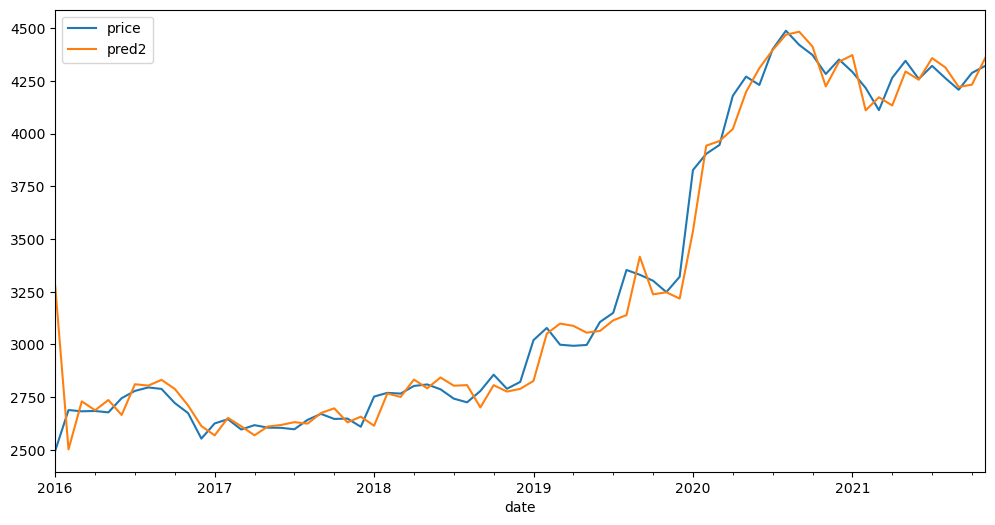

In [93]:
train[['price','pred2']].plot(figsize=(12,6))
plt.show();

In [94]:
import warnings
warnings.filterwarnings("ignore")

##### AutoARIMA to know the best model on the basis of AIC

In [95]:
#!pip install pmdarima
from pmdarima import auto_arima

In [96]:
auto = auto_arima(train['price'], trace = True, supress_warnings = True, seasonal = False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=841.460, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=842.367, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=841.861, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=844.457, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.425 seconds


In [97]:
# P =0, d=1, q =1
model_4 = ARIMA(train['price'], order=(0,1,1))
results_4 = model_4.fit()

In [98]:
pred3 = results_4.predict()
pred3

date
2016-01-31       0.000000
2016-02-29    2501.633761
2016-03-31    2732.488833
2016-04-30    2670.571289
2016-05-31    2687.726774
                 ...     
2021-07-31    4235.452041
2021-08-31    4342.751382
2021-09-30    4243.211306
2021-10-31    4199.444426
2021-11-30    4309.878963
Freq: M, Name: predicted_mean, Length: 71, dtype: float64

In [99]:
rmse4 = np.sqrt(mean_squared_error(train['price'],pred3))
rmse4

311.57226827024124

# SARIMAX

In [100]:
#!pip install skforecast
from skforecast.model_selection_statsmodels import grid_search_sarimax

#### GridSearch CV

In [101]:
param_grid = {'order': [(12, 0, 0), (12, 2, 0), (12, 1, 0), (12, 1, 1), (14, 1, 4)],
             'seasonal_order': [(0, 0, 0, 0)],
             'trend': [None, 'n', 'c']}

results_grid = grid_search_sarimax(
                y = train['price'],
                param_grid = param_grid,
                initial_train_size = 5,
                steps = 7,
                metric = 'mean_absolute_error',
                refit = False,
                verbose = False,
                fit_kwargs = {'maxiter': 200, 'disp': 0}
             )

print(results_grid.to_markdown(tablefmt="github", index=False))

root       INFO  Number of models compared: 15
100%|█████████████████████████████████████████████████████| 15/15 [00:44<00:00,  2.97s/it]

| params                                                               |   metric | order      | seasonal_order   | trend   |
|----------------------------------------------------------------------|----------|------------|------------------|---------|
| {'order': (12, 0, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': None} |  188.209 | (12, 0, 0) | (0, 0, 0, 0)     |         |
| {'order': (12, 0, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': 'n'}  |  188.209 | (12, 0, 0) | (0, 0, 0, 0)     | n       |
| {'order': (14, 1, 4), 'seasonal_order': (0, 0, 0, 0), 'trend': None} |  208.875 | (14, 1, 4) | (0, 0, 0, 0)     |         |
| {'order': (14, 1, 4), 'seasonal_order': (0, 0, 0, 0), 'trend': 'n'}  |  208.875 | (14, 1, 4) | (0, 0, 0, 0)     | n       |
| {'order': (14, 1, 4), 'seasonal_order': (0, 0, 0, 0), 'trend': 'c'}  |  211.621 | (14, 1, 4) | (0, 0, 0, 0)     | c       |
| {'order': (12, 1, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': None} |  252.138 | (12, 1, 0) | (0, 0, 0, 0)     |   

In [102]:
param_grid = {'order': [(1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 1, 1), (2, 1, 0),(2, 1, 2),(2, 2, 2),(2, 0, 2)],
             'seasonal_order': [(0, 0, 0, 0)],
             'trend': [None, 'n', 'c']}

results_grid = grid_search_sarimax(
                y = train['price'],
                param_grid = param_grid,
                initial_train_size = 5,
                steps = 7,
                metric = 'mean_absolute_error',
                refit = False,
                verbose = False,
                fit_kwargs = {'maxiter': 200, 'disp': 0}
             )

print(results_grid.to_markdown(tablefmt="github", index=False))

root       INFO  Number of models compared: 24
100%|█████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.27it/s]

| params                                                              |   metric | order     | seasonal_order   | trend   |
|---------------------------------------------------------------------|----------|-----------|------------------|---------|
| {'order': (2, 1, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': 'n'}  |  164.577 | (2, 1, 0) | (0, 0, 0, 0)     | n       |
| {'order': (2, 1, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': None} |  164.577 | (2, 1, 0) | (0, 0, 0, 0)     |         |
| {'order': (1, 0, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': None} |  170.238 | (1, 0, 0) | (0, 0, 0, 0)     |         |
| {'order': (1, 0, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': 'n'}  |  170.238 | (1, 0, 0) | (0, 0, 0, 0)     | n       |
| {'order': (1, 1, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': 'c'}  |  170.573 | (1, 1, 0) | (0, 0, 0, 0)     | c       |
| {'order': (1, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'trend': 'n'}  |  171.055 | (1, 1, 1) | (0, 0, 0, 0)     | n       |
| {'orde

In [103]:
# from above gridsearch we observe best order as (2,1,0) 

### SARIMAX with order=(2,1,0,), seasonal_order = (2,1,0,12)

In [104]:
import statsmodels.api as sm

In [105]:
model_max = sm.tsa.statespace.SARIMAX(train['price'], order=(2,1,0,), seasonal_order = (2,1,0,12))
result_max = model_max.fit()

In [106]:
pred_max = result_max.predict()

In [107]:
rmse_max_train = np.sqrt(mean_squared_error(pred_max, train['price']))

In [108]:
rmse_max_train

340.88683581491324

### SARIMAX with seasonal_order = (2,1,0,22)

In [109]:
model_max1 = sm.tsa.statespace.SARIMAX(train['price'], order=(2,1,0,), seasonal_order = (2,1,0,22))
result_max1 = model_max1.fit()

In [110]:
pred_max1 = result_max1.predict()

In [111]:
rmse_max_train1 = np.sqrt(mean_squared_error(pred_max1, train['price']))

#### Training Rmse

In [112]:
rmse_max_train1

348.813644783817

In [113]:
pred_max1_test = result_max1.forecast(1)
pred_max1_test

2021-12-31    4364.87264
Freq: M, dtype: float64

In [114]:
test

price    4324.406667
Name: 2021-12-31 00:00:00, dtype: float64

In [115]:
rmse_max_test1 = np.sqrt(mean_squared_error(pred_max1_test, test))

###### Testing Rmse

In [116]:
rmse_max_test1

40.46597354639107

### Best Model - Triple Exponential Smoothing with Tend and Seasonality As Additive

In [117]:
fitted_TESadd12 = ExponentialSmoothing(train['price'],trend='add',seasonal='add',seasonal_periods=12).fit()
train['TESadd12'] = fitted_TESadd12.fittedvalues.shift(-1)

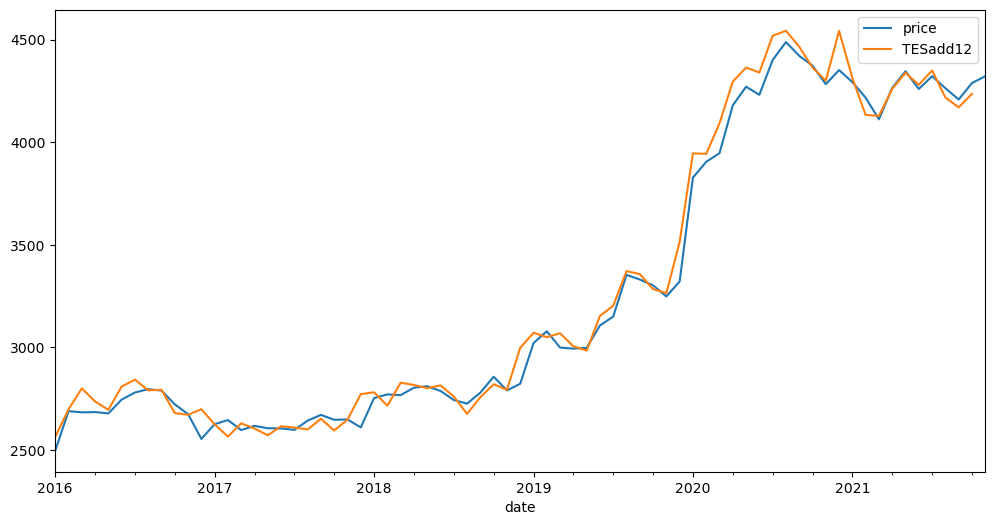

In [118]:
train[['price','TESadd12',]].plot(figsize=(12,6))
plt.show();

#### Forecasting for next 1 month

In [119]:
test_pred3 = fitted_TESadd12.forecast(1)
test_pred3

2021-12-31    4328.992996
Freq: M, dtype: float64

##### RMSE

In [120]:
rmse3 = np.sqrt(mean_squared_error(test_original,test_pred3 ))
rmse3

4.5863291880623365

In [121]:
pred3_train = fitted_TESadd12.predict(0)
pred3_train.head()

date
2016-01-31    2489.784223
2016-02-29    2563.344841
2016-03-31    2696.993030
2016-04-30    2799.448515
2016-05-31    2736.268403
Freq: M, dtype: float64

In [122]:
rmse3_train = np.sqrt(mean_squared_error(train_original,pred3_train))
rmse3_train

80.70883583910064

### Forecasting

In [123]:
forecast = fitted_TESadd12.forecast(4)
forecast

2021-12-31    4328.992996
2022-01-31    4507.038165
2022-02-28    4555.179739
2022-03-31    4522.484059
Freq: M, dtype: float64

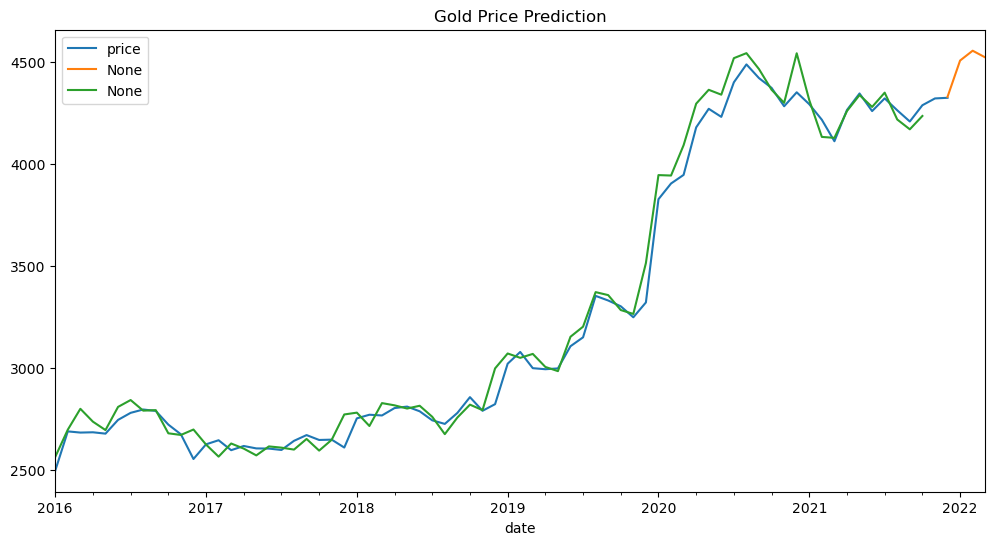

In [124]:
title = 'Gold Price Prediction'
ylabel='Price'
xlabel='Month' 
new.plot(legend=True,figsize=(12,6),title=title)
forecast.plot(legend=True)
pred3_train.shift(-1).plot(legend=True)
plt.show();

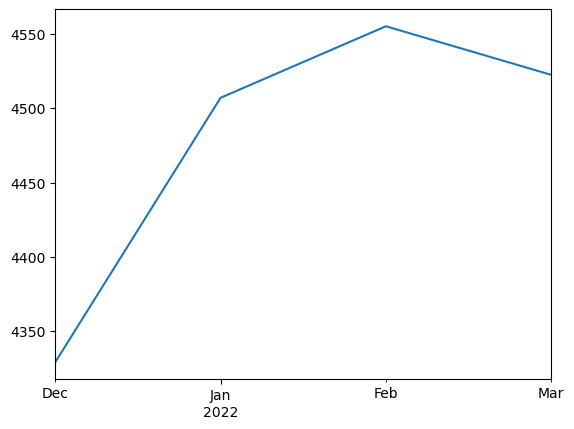

In [125]:
forecast.plot()
plt.show();

In [145]:
from pickle import dump

In [146]:
dump(fitted_TESadd12, open('cl.sav','wb'))